# $\delta_F$-vs-$\rho_{DM}$

In [118]:
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter as gf

def get_deltaF_deltam_est(n , z=2.4):
    """Estimator for each mock"""
    mockmap = np.fromfile('./spectra/maps/map_TNG_z'+str(z)+'_n'+str(n)+'.dat')
    deltaF_mock = np.ravel(gf(mockmap.reshape(205,205,205), 4, mode='wrap'))
    DM = np.ravel(gf(h5py.File('./TNG_DensField/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:], 4 , mode='wrap'))
    co = np.polyfit(deltaF_mock, DM, 2)
    
    return co

def get_deltaF_deltam_mean_std(nmocks=20, z=2.4):
    """Get the mean and stdev of the estimator's parameters"""
    co_all = np.empty((nmocks, 3))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        co = np.array(get_deltaF_deltam_est(n, z=z))
        co_all[i,:] = co
        
    mean = np.mean(co_all, axis=0)
    std = np.std(co_all, axis=0)
    for i in range(3):
        print(str(np.around(mean[i],2))+'+-'+ str(np.around(std[i],2)))
    return mean, std   

In [119]:
get_deltaF_deltam_mean_std(z=2.4)

11.43+-0.49
-4.59+-0.05
0.97+-0.01


(array([11.42593838, -4.58656995,  0.97354562]),
 array([0.48889537, 0.05352328, 0.00500886]))

In [102]:
get_deltaF_deltam_mean_std(z=2.3)

18.87+-0.72
-5.66+-0.07
0.96+-0.01


In [103]:
get_deltaF_deltam_mean_std(z=2.6)

13.0+-0.76
-4.98+-0.06
0.99+-0.0


The relation is very redshift sensitive!!

In [128]:
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
import mass_calcs
import matplotlib

def deltaF_true_mock(nmocks=20):
    matplotlib.rc('axes',edgecolor='k')
    
    # Set the axes
    plt.style.use('Notebook.mystyle')
    left, width = .2, .70
    bottom2, height2 = .48, .38
    bottom1, height1 = .1, .38
    
    rect_scatter1 = [left, bottom1, width, height1]
    rect_scatter2 = [left, bottom2, width, height2]
    rect_histx = [left, bottom2 + height2, width, 0.1]
    rect_histy1 = [left + width , bottom1, 0.1, height1]
    rect_histy2 = [left + width , bottom2, 0.1, height2]
    
    fig = plt.figure(figsize=(8, 16))
    ax1 = fig.add_axes(rect_scatter1)
    ax2 = fig.add_axes(rect_scatter2)
    ax_histx = fig.add_axes(rect_histx, sharex=ax2)
    ax_histy1 = fig.add_axes(rect_histy1, sharey=ax1)
    ax_histy2 = fig.add_axes(rect_histy2, sharey=ax2)
    ax2.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy1.tick_params(axis="y", labelleft=False)
    ax_histy2.tick_params(axis="y", labelleft=False)
    ax_histy2.tick_params(axis="x", labelbottom=False)
    
    # Plot deltaF true and mock

    

    #deltaF_mock_fgpa = np.ravel(gaussian_filter(np.fromfile('./FGPA/map_TNG_z2.4_FGPA.dat').reshape(205,205,205), 4, mode='wrap'))
    # Scale the true map's amplitude to that of IGM
    
    x = np.arange(-0.4,0.4,0.01)
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    htot1 = np.zeros((nmocks, bins[0].size-1, bins[0].size-1))
    htot2 = np.zeros((nmocks, bins[0].size-1, bins[1].size-1))
    DM = np.ravel(gaussian_filter(h5py.File('./TNG_DensField/TNG_DM_z2.4.hdf5','r')['DM/dens'][:], 4, mode='wrap'))
    
    for i,n in enumerate(np.arange(1,nmocks+1)):
        mockmap = np.fromfile('./spectra/maps/map_TNG_z2.4_n'+str(n)+'.dat')
        deltaF_mock = np.ravel(gaussian_filter(mockmap.reshape(205,205,205), 4, mode='wrap'))
        with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
            deltaF_true = np.ravel(gaussian_filter(ftrue['map'][:], 4, mode='wrap'))
        deltaF_true *= np.std(deltaF_mock)/np.std(deltaF_true)
        deltaF_mock = np.ravel(gaussian_filter(np.fromfile('./spectra/maps/map_TNG_z2.4_n'+str(n)+'.dat').reshape(205,205,205), 4, mode='wrap'))
        h1,_, _ = np.histogram2d(deltaF_mock, deltaF_true, bins=[bins[0],bins[0]], density=True)
        h2, _, _= np.histogram2d(deltaF_mock, DM, bins=bins, density=True)
        
        htot1[i,:,:] = h1
        htot2[i,:,:] = h2
    axes = [ax1,ax2]
    extent = ([bins[0][0], bins[0][-1], bins[0][0], bins[0][-1]], [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
    for i, h in enumerate([htot1,htot2]):
        hmean = np.median(h, axis=0)
        im = axes[i].imshow(np.rot90(hmean), cmap=plt.cm.gist_heat.reversed(), norm=matplotlib.colors.LogNorm(vmin=.01, vmax=10), extent = extent[i], aspect='auto' )
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(axes[i],width="100%", height="100%",  bbox_to_anchor=(0.9,0.5, 0.02, 0.4), bbox_transform=axes[i].transAxes)
        cb_ticks_pos = 'left'
        cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[1e-2,1e-1, 1, 10,100])
        cb.ax.yaxis.set_tick_params(color='k')
        cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
        cb.ax.yaxis.set_label_position(cb_ticks_pos)
        plt.setp(plt.getp(axins, 'yticklabels'), color='k')
        cb.ax.set_ylabel('2-D PDF', labelpad=5, color='k', fontsize=20)

    for z in [2.3, 2.4, 2.6]:
        co, _ = get_deltaF_deltam_mean_std(nmocks=20, z=z)
        ax2.plot(x, np.polyval(co,x), label='z='+str(z))

    
    ## Fit line
    #co = np.polyfit(deltaF_true, deltaF_mock, 2)
    #x = np.arange(-0.4,0.4,0.01)
    #ax1.plot(x, np.polyval(co,x), label='our fit', ls='--')

    ax1.set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax1.set_ylabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, noiseless}}$')
    ax2.set_ylabel(r'$\rm  \left(\frac{\rho_{DM}}{ \langle \rho_{DM} \rangle}\right)^{\rm sm}$', fontsize=40)
    ax1.set_xlim(-0.35,0.25)
    ax1.set_ylim(-0.35,0.25)
    ax2.set_xlim(-0.35,0.25)
    ax2.set_ylim(0,3.5)
    ax1.set_yticks(ticks = np.arange(-.3,.3,.1))
    ax1.set_xticks(ticks = np.arange(-.3,.3,.1))
    ax1.plot([-.3,.2],[-.3,.2], label='1:1', color='C1')
    ax1.legend(loc='lower right')
    ax2.legend(loc='lower left', fontsize=20)
    
    
    # Marginal hist
    ax_histx.hist(deltaF_mock, histtype='step', bins=np.arange(-.5,.5,0.003), density=True, color='k')
    ax_histy1.hist(deltaF_true, histtype='step', bins=np.arange(-.5,.5,0.003), orientation='horizontal', density=True, color='k')
    ax_histy2.hist(DM, histtype='step', bins=np.arange(0,6,0.003), orientation='horizontal', density=True, color='k')
    ax_histx.set_axis_off()
    ax_histy1.set_axis_off()
    ax_histy2.set_axis_off()
    
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', colors='k')
        ax.tick_params(axis='y', colors='k')
        ax.yaxis.label.set_color('k')
        ax.xaxis.label.set_color('k')
        ax.set_xticks(ticks= np.arange(-.3,.3,.1))
        plt.setp(ax.get_xticklabels(), rotation=20, fontsize=20)
    
    plt.tight_layout()
    plt.savefig('deltam_deltaF_z2.4.pdf')
    #plt.savefig('deltam_deltaF_z2.4.png', transparent=False)


18.87+-0.72
-5.66+-0.07
0.96+-0.01
11.43+-0.49
-4.59+-0.05
0.97+-0.01
13.0+-0.76
-4.98+-0.06
0.99+-0.0


<ipython-input-128-47d5fb2f40c7>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


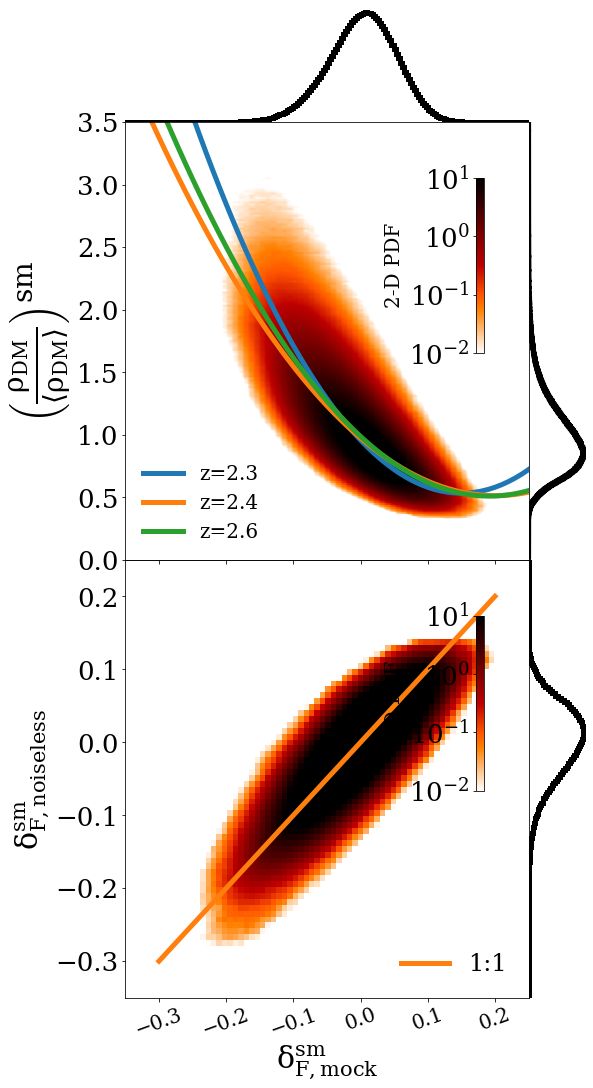

In [129]:
deltaF_true_mock()

In [5]:
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
import mass_calcs
import matplotlib

def deltaF_true_mock(nmocks=20):
    matplotlib.rc('axes',edgecolor='k')
    
    # Set the axes
    plt.style.use('Notebook.mystyle')
    fig, ax = plt.subplots(2,2, figsize=(16, 16))
 
    
    # Plot deltaF true and mock

    

    #deltaF_mock_fgpa = np.ravel(gaussian_filter(np.fromfile('./FGPA/map_TNG_z2.4_FGPA.dat').reshape(205,205,205), 4, mode='wrap'))
    # Scale the true map's amplitude to that of IGM
    
    x = np.arange(-0.4,0.4,0.01)
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    htot1 = np.zeros((nmocks, bins[0].size-1, bins[0].size-1))
    htot2 = np.zeros((nmocks, bins[0].size-1, bins[1].size-1))
    DM = np.ravel(gaussian_filter(h5py.File('./TNG_DensField/TNG_DM_z2.4.hdf5','r')['DM/dens'][:], 4, mode='wrap'))
    
    for i,n in enumerate(np.arange(1,nmocks+1)):
        mockmap = np.fromfile('./spectra/maps/map_TNG_z2.4_n'+str(n)+'.dat')
        deltaF_mock = np.ravel(gaussian_filter(mockmap.reshape(205,205,205), 4, mode='wrap'))
        with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
            deltaF_true = np.ravel(gaussian_filter(ftrue['map'][:], 4, mode='wrap'))
        deltaF_true *= np.std(deltaF_mock)/np.std(deltaF_true)
        deltaF_mock = np.ravel(gaussian_filter(np.fromfile('./spectra/maps/map_TNG_z2.4_n'+str(n)+'.dat').reshape(205,205,205), 4, mode='wrap'))
        h1,_, _ = np.histogram2d(deltaF_mock, deltaF_true, bins=[bins[0],bins[0]], density=True)
        h2, _, _= np.histogram2d(deltaF_mock, DM, bins=bins, density=True)
        
        htot1[i,:,:] = h1
        htot2[i,:,:] = h2
        
    extent = ([bins[0][0], bins[0][-1], bins[0][0], bins[0][-1]], [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
    for i, h in enumerate([htot1,htot2]):
        hmean = np.median(h, axis=0)
        hstd = np.std(htot, axis=0)
        im = axes[i,0].imshow(np.rot90(hmean), cmap=plt.cm.gist_heat.reversed(), norm=matplotlib.colors.LogNorm(vmin=.01, vmax=10), extent = extent[i], aspect='auto' )
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(axes[i,0],width="100%", height="100%",  bbox_to_anchor=(0.9,0.5, 0.02, 0.4), bbox_transform=axes[i,0].transAxes)
        cb_ticks_pos = 'left'
        cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[1e-2,1e-1, 1, 10,100])
        cb.ax.yaxis.set_tick_params(color='k')
        cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
        cb.ax.yaxis.set_label_position(cb_ticks_pos)
        plt.setp(plt.getp(axins, 'yticklabels'), color='k')
        cb.ax.set_ylabel('2-D PDF', labelpad=5, color='k', fontsize=20)
        
        im = ax[i,1].imshow(np.rot90(hstd), cmap=plt.cm.gist_heat.reversed(), norm=matplotlib.colors.LogNorm(vmin=.01, vmax=10), extent = [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]], aspect='auto' )
    
    co, _ = get_deltaF_deltam_mean_std(nmocks=20)
    
    ax[0,0].plot(x, np.polyval(co,x), label='Power-law estimator')
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax[i,1],width="100%", height="100%",  bbox_to_anchor=(0.05,0.05, 0.02, 0.6), bbox_transform=ax[i,1].transAxes)
    cb_ticks_pos = 'right'
    cb = fig2.colorbar(im, cax=axins, orientation='vertical')
    cb.ax.yaxis.set_tick_params(color='k')
    cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
    cb.ax.yaxis.set_label_position(cb_ticks_pos)
    plt.setp(plt.getp(axins, 'yticklabels'), color='k')
    cb.ax.set_ylabel('2-D PDF', labelpad=5, color='k', fontsize=20)

    
    ## Fit line
    #co = np.polyfit(deltaF_true, deltaF_mock, 2)
    #x = np.arange(-0.4,0.4,0.01)
    #ax1.plot(x, np.polyval(co,x), label='our fit', ls='--')
    """
    ax.set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax1.set_ylabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, noiseless}}$')
    ax2.set_ylabel(r'$\rm  \left(\frac{\rho_{DM}}{ \langle \rho_{DM} \rangle}\right)^{\rm sm}$', fontsize=40)
    ax1.set_xlim(-0.35,0.25)
    ax1.set_ylim(-0.35,0.25)
    ax2.set_xlim(-0.35,0.25)
    ax2.set_ylim(0,3.5)
    ax1.set_yticks(ticks = np.arange(-.3,.3,.1))
    ax1.set_xticks(ticks = np.arange(-.3,.3,.1))
    ax1.plot([-.3,.2],[-.3,.2], label='1:1', color='C1')
    ax1.legend(loc='lower right')
    ax2.legend(loc='lower left', fontsize=20)
    
    
    # Marginal hist
    ax_histx.hist(deltaF_mock, histtype='step', bins=np.arange(-.5,.5,0.003), density=True, color='k')
    ax_histy1.hist(deltaF_true, histtype='step', bins=np.arange(-.5,.5,0.003), orientation='horizontal', density=True, color='k')
    ax_histy2.hist(DM, histtype='step', bins=np.arange(0,6,0.003), orientation='horizontal', density=True, color='k')
    ax_histx.set_axis_off()
    ax_histy1.set_axis_off()
    ax_histy2.set_axis_off()
    
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', colors='k')
        ax.tick_params(axis='y', colors='k')
        ax.yaxis.label.set_color('k')
        ax.xaxis.label.set_color('k')
        ax.set_xticks(ticks= np.arange(-.3,.3,.1))
        plt.setp(ax.get_xticklabels(), rotation=20, fontsize=20)
    """
    #plt.tight_layout()
    #plt.savefig('deltam_deltaF_z2.4.pdf')
    #plt.savefig('deltam_deltaF_z2.4.png', transparent=False)


# $M_{DM}$-vs-$M_{tomo}$:

### Find optimal offset in $M_{tomo}$:

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import importlib
plt.style.use('paper.mystyle')

def find_optimal_offset(ax, Mtomo, MDM, ls, label):
    offset_range = np.arange(0,1,0.0001)
    err = np.array([])
    for offset in offset_range:
        dev = MDM - (Mtomo+offset)
        err = np.append(err, np.sqrt(np.mean(dev*dev)))
    ind = np.where(err == np.min(err))
    print('Minimum error is at offset = ', offset_range[ind])
    ax.plot(offset_range, err, ls=ls, label=label)

    
    
def get_id_max_overlap(lmap_mock, lmap_true):
    """Slightly improved compared to the one used for old plots of Mtomo vs Mtomo. In this case,
    the minima in the labeled map are not numbered in order, so we can miss some numbers in between.
    returns : A dictionary of the corresponding ids of overlapping structures, just returns those structures which have
    overlapping structures in true map"""
    minima_mock = np.unique(lmap_mock)
    minima_true = np.unique(lmap_true)
    minima_mock = np.delete(minima_mock, np.where(minima_mock==0))
    minima_true = np.delete(minima_true, np.where(minima_true==0))
    
    
    id_max_overlap = {'mock':np.array([]),'true':np.array([])}
    for i in minima_mock:
        indm = np.where(lmap_mock==i)
        idtrue, counts = np.unique(lmap_true[indm], return_counts=True)
        if idtrue[0] == 0:
            idtrue = np.delete(idtrue, 0)
            counts = np.delete(counts, 0)
            if counts.size== 0 :
                continue
        counts_sorted = np.sort(counts)
        # Here, If 2 sub-contours overlap identically, we pick just the one with lower id
        indt = np.where(counts == counts_sorted[-1])[0][0]
        if idtrue[indt]!=0 :
            id_max_overlap['mock'] = np.append(id_max_overlap['mock'], i)
            id_max_overlap['true'] = np.append(id_max_overlap['true'], idtrue[indt])
    id_max_overlap['true'].astype(int); id_max_overlap['mock'].astype(int)
    return id_max_overlap

def get_MDM(n=1, z=2.4, th=2.35, lc=2.0):
    
    import LATIS
    import importlib
    from LATIS.codes import minima
    importlib.reload(minima)
    with h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r') as f:
        lmap_mock = f['map'][:]
    with h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_true_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r') as f :
        lmap_true = f['map'][:]
    peaks_mock = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')
    peaks_true = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_true_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r')

    DM = h5py.File('./TNG_DensField/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:]
    z_accurate = h5py.File('./spectra/spectra_TNG_z'+str(z)+'_n1.hdf5','r')['Header'].attrs['redshift']
    
    DM *= minima.convert_Delta_Msol_ph(z=z_accurate)
    MDM_true = np.array([])
    MDM_mock = np.array([])
    MDM_mock_true = np.array([])
    for i in range(1, peaks_mock['mtomo'].size+1):
        ind = np.where(lmap_mock == i)
        MDM_mock = np.append(MDM_mock, np.log10(np.sum(DM[ind])))
    for i in range(1, peaks_true['mtomo'].size+1):
        ind = np.where(lmap_true == i)
        MDM_true = np.append(MDM_true, np.log10(np.sum(DM[ind])))
    
    id_max_overlap = get_id_max_overlap(lmap_mock=lmap_mock, lmap_true=lmap_true)
    for i in id_max_overlap['true'][:]:
        ind = np.where(lmap_true==i)
        MDM_mock_true = np.append(MDM_mock_true, np.log10(np.sum(DM[ind])))
    return peaks_mock['mtomo'][:], peaks_true['mtomo'][:], MDM_mock, MDM_true, MDM_mock_true, id_max_overlap


In [3]:
def write_data(z=2.4, th=2.35, lc=2.00, offset=0.214):
    with h5py.File('./DataPaper/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5','w') as fw:
        for n in range(1,21):
            Mtomo_mock, Mtomo_true, MDM_mock, MDM_true, MDM_mock_true, id_max_overlap = get_MDM(n=n, z=z, th=th, lc=lc)
            fw[str(n)+'/Mtomo_mock'] = Mtomo_mock[:]+offset
            fw[str(n)+'/MDM_mock'] = MDM_mock[:]
            fw[str(n)+'/Mtomo_mock_overlap'] = Mtomo_mock[:][id_max_overlap['mock'][:].astype(int)-1]+offset
            fw[str(n)+'/MDM_true_overlap'] = MDM_mock_true
            fw[str(n)+'/id_max_overlap/mock'] = id_max_overlap['mock'][:]
            fw[str(n)+'/id_max_overlap/true'] = id_max_overlap['true'][:]

In [40]:
def make_a_pool(nrange, z=2.4, th=2.35, lc=2.00):
    """Make a pool of all strucutres in all mocks"""
    Mtomo = np.array([])
    MDM = np.array([])
    f = h5py.File('./DataPaper/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5','r')
    for n in nrange:
        Mtomo = np.append(Mtomo, f[str(int(np.around(n)))+'/Mtomo_mock_overlap'][:])
        MDM = np.append(MDM, f[str(int(np.around(n)))+'/MDM_true_overlap'][:])

    # Randomize the pool
    ind_rnd = np.random.choice(np.arange(Mtomo.size), size= Mtomo.size, replace=False)
    Mtomo = Mtomo[ind_rnd]
    MDM = MDM[ind_rnd]

    return Mtomo, MDM


def plot_different_fits(train_size=16, z=2.4, th=2.35, lc=2.00):
    
    import scipy.stats
    from scipy.stats import linregress
    
    fig, ax = plt.subplots(figsize=(5,5))
    x = np.arange(13,16.5, 1)
    f = h5py.File('./DataPaper/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5','r')
    slopes = []
    intercepts = []
    ntrain = np.random.choice(np.arange(1,21), size= train_size, replace=False)
    y = np.zeros((train_size, x.size))
    for i, n in enumerate(ntrain):
        Mtomo_mock = f[str(n)+'/Mtomo_mock_overlap'][:]
        co = linregress(Mtomo_mock[:] - 14, f[str(n)+'/MDM_true_overlap'][:])
        slopes.append(co[0])
        intercepts.append(co[1])
        ax.plot(x, co[0]*(x-14)+co[1], alpha=0.7, lw=1)
        y[i] = co[0]*(x-14)+co[1]
    mean = np.mean(y, axis=0)
    #ax.plot(x, mean, lw=4)
    std = np.std(y, axis=0)
    
    slope_mean = np.mean(slopes)
    intercept_mean = np.mean(intercepts)
    print('Slope : ', str(slope_mean)[:5]+'+-'+str(np.std(slopes))[:5])
    print('Intercept : ', str(intercept_mean)[:5]+'+-'+str(np.std(intercepts))[:5])
    ax.fill_between(x=x, y1=mean-std, y2=mean+std, color='C3', alpha=0.4, edgecolor='None')
    
    
    ax.set_xlim((13,16))
    ax.set_ylim((13,16))
    ax.set_xlabel(r'$\mathrm{M_{tomo, mock}}$')
    ax.set_ylabel(r'$\mathrm{M_{DM, noiseless}}$')
    
    return ntrain, (intercept_mean, slope_mean)

def test_fit(co, ntest, z=2.4, th=2.35, lc=2.00, bins=np.array([13, 14, 14.5, 15.5])):
    """Find the errors for in mass bins of bins for the mock maps array of ntest"""
    
    fit = lambda x : co[1]*(x-14) +co[0]
    Mtomo, MDM = make_a_pool(ntest,z=z, th=th, lc=lc)
    
    err = []
    for i in range(bins.size-1):
        ind = np.where( (Mtomo > bins[i])*(Mtomo < bins[i+1]))
        dev = fit(Mtomo[ind]) - MDM[ind]
        err.append(np.sqrt(np.sum(dev*dev)/dev.size))
    
    return err

In [5]:
def get_kde(M1, M2, mmin= 13, mmax= 16):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)  
    X, Y = np.mgrid[mmin:mmax:50j, mmin:mmax:50j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z

def get_mean_KDE(z, th, lc, nmocks=20, first_plot=True):
    f = h5py.File('./DataPaper/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5','r')
    Zall = []
    if first_plot:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:]))
    else:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock_overlap'][:], f[str(n)+'/MDM_true_overlap'][:]))
    f.close()
    
    Zmean = np.zeros(shape=(50,50))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    
    return Zmean
        

In [6]:
def plot_Mtomo_MDM(fig, ax, Mtomo, MDM, z, th, lc, signif=None, linear_transform=False, title='', xlabel=r'$\rm log[M_{tomo}]$',  ylabel=r'$\rm log[M_{DM, noiseless}]$',
                   data_for_Drew=None, co=None, legend=True, plot_kde=False, first_plot=True):
    
    import scipy.stats
    from scipy.stats import linregress
    
    mmin, mmax = 13, 16
    
    if plot_kde :
        
        Z = get_mean_KDE(z=z, th=th, lc=lc, first_plot=first_plot)
        im = ax.imshow(np.rot90(Z), cmap=plt.cm.viridis, extent = [mmin, mmax, mmin, mmax] )
        cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.25, shrink=0.7)
        
        cb.ax.set_xlabel('Gaussian KDE')
    
    if co is None:
        co = linregress(Mtomo-14, MDM)
        #print('fitting line :', co)
    if linear_transform:
        Mtomo *= co[0]
        Mtomo += co[1]
    else :
        x = np.array([13-14,16])
        ax.plot(x, co[0]*(x-14)+co[1], alpha=0.7, label='power-law estimator',ls='dotted', lw=8)
    
    ax.plot([13,16],[13,16], alpha=0.4, color='k', label='1:1', ls='--', lw=8)

    if signif is None :
        ax.scatter(Mtomo, MDM, alpha=0.3)
    else :
        ind1 = (signif > -2.5)*(signif < -2.35)
        ind2 = (signif > -3.0)*(signif < -2.5)
        ind3 = (signif > -3.5)*(signif < -3.0)
        ind4 = (signif < -3.5)
        ax.scatter( Mtomo[ind1], MDM[ind1], alpha=0.6, label=r'$-2.5 < \sigma < -2.35$', s=50, facecolor='None', edgecolor='r', marker='^', lw=2)
        ax.scatter( Mtomo[ind2], MDM[ind2], alpha=0.6, label=r'$-3.0 < \sigma < -2.5$', s=50, facecolor='None', edgecolor='k', marker='s', lw=2)
        ax.scatter( Mtomo[ind3], MDM[ind3], alpha=0.6, label=r'$-3.5 < \sigma < -3.0$', s=50, facecolor='None', edgecolor='b', marker='o', lw=2)
        ax.scatter( Mtomo[ind4], MDM[ind4], alpha=0.6, label=r'$ \sigma < -3.5 $', s=50, facecolor='None', edgecolor='w', marker='D', lw=2)
        if data_for_Drew is not None:
            fw = h5py.File(data_for_Drew, 'w')
            fw['Mtomo'] = Mtomo
            fw['MDM'] = MDM
            fw['signif'] = signif
    
    bins = [13,14,14.5,15.5]
    std = []
    co = [co[0], co[1]]
    for b in range(1,len(bins)):
        ind = np.where((Mtomo[:] > bins[b-1])*(Mtomo[:] < bins[b]))
        #print('diff = ', MDM[ind] - Mtomo[ind])
        dev = MDM[ind] - np.polyval(co, Mtomo[ind])
        #print('dev = ', dev)
        std.append(np.sqrt(np.mean(dev*dev)))
    #print('RMS scatter around the fit in bins of ', bins, ' are :', std)
    dev = MDM - np.polyval(co, Mtomo)
    #print(' The total RMS scatter around the fit is : ', np.sqrt(np.mean(dev*dev)))
        
    ax.set_xlim((13,16))
    ax.set_ylim((13,16))
    ax.set_xticks(np.arange(13.5,16,.5))
    ax.set_yticks(np.arange(13.5,16,.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.7)
    ax.set_title(title)
    if legend:
        ax.legend( framealpha=0.7, loc=(1.05, 0.2), fontsize=18, facecolor='gray', frameon=True)        
    plt.setp(ax.get_xticklabels(), rotation=40)

In [7]:
def plot_for_paper(n, z, th, lc, co=(0.40,14.50)):
    """Helper function"""
    f = h5py.File('./DataPaper/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5','r')
    fig, ax = plt.subplots(1,2, figsize=(18,9))

    signif = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')['signif'][:]
    plot_Mtomo_MDM(fig, ax[0], f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:], z=z, th= th, lc=lc, signif=signif,
    xlabel=r'$\rm log [ M_{tomo} ]$', ylabel=r'$\rm log [ M_{DM, mock}]$', legend=False, plot_kde=True, 
    first_plot=True)

    signif = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')['signif'][:]
    signif = signif[f[str(n)+'/id_max_overlap/mock'][:].astype(int)-1]

    plot_Mtomo_MDM(fig, ax[1], f[str(n)+'/Mtomo_mock_overlap'][:], f[str(n)+'/MDM_true_overlap'][:], z=z, th=th, lc=lc, 
                   signif=signif, co=co, legend=True, plot_kde=True, first_plot=False)
    
    
    f.close()
    plt.tight_layout(pad=0)
    return fig

## $z=2.3, 2.4, 2.6$ and $\nu = -2.0$, $\kappa = -2.35$ :

In [95]:
def get_offset():
    z, ls= [2.3,2.4,2.6], ['--','solid','dotted']
    fig, ax = plt.subplots()
    ax.set_xlabel('offset (dex)')
    ax.set_ylabel(r'$rms \ M_{tomo, raw} - M_{DM, mock}$')
    for i in range(3):
        Mtomo_mock, _, MDM_mock, _, _, _ = get_MDM(n=1, z=z[i], th=2.35, lc=2.00)
        find_optimal_offset(ax, Mtomo_mock, MDM_mock, ls=ls[i], label='z='+str(z[i]))
    ax.legend()

Minimum error is at offset =  [0.6392]
Minimum error is at offset =  [0.2133]
Minimum error is at offset =  [0.6222]


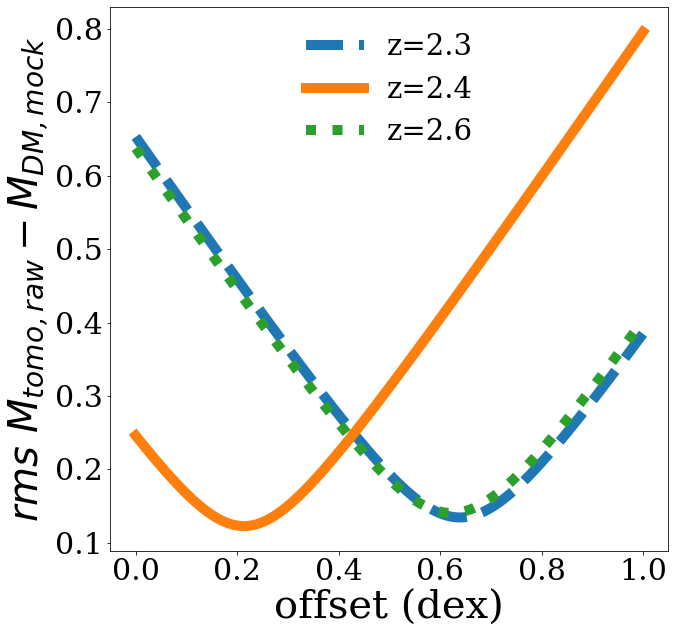

In [96]:
get_offset()

In [ ]:
write_data(z=2.3, th=2.35, lc=2.00, offset=0.640)
write_data(z=2.6, th=2.35, lc=2.00, offset=0.622)

In [8]:
write_data(z=2.4, th=2.35, lc=2.00, offset=0.214)

In [9]:
def test():
    print(h5py.File('./DataPaper/Mtomo_MDM_z2.4_th2.35_lc2.00.hdf5','r')['1'].keys())
test()

<KeysViewHDF5 ['MDM_mock', 'MDM_true_overlap', 'Mtomo_mock', 'Mtomo_mock_overlap', 'id_max_overlap']>


### z=2.3 :

Mean fit :

Slope :  0.435+-0.088
Intercept :  14.58+-0.061


[0.38386991831465683, 0.353638439395368, 0.34569702438540734]

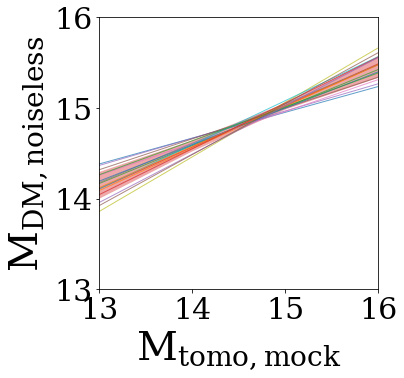

In [94]:
ntrain, co = plot_different_fits(z=2.3, th=2.35, lc=2.00)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.3, th=2.35, lc=2.00)

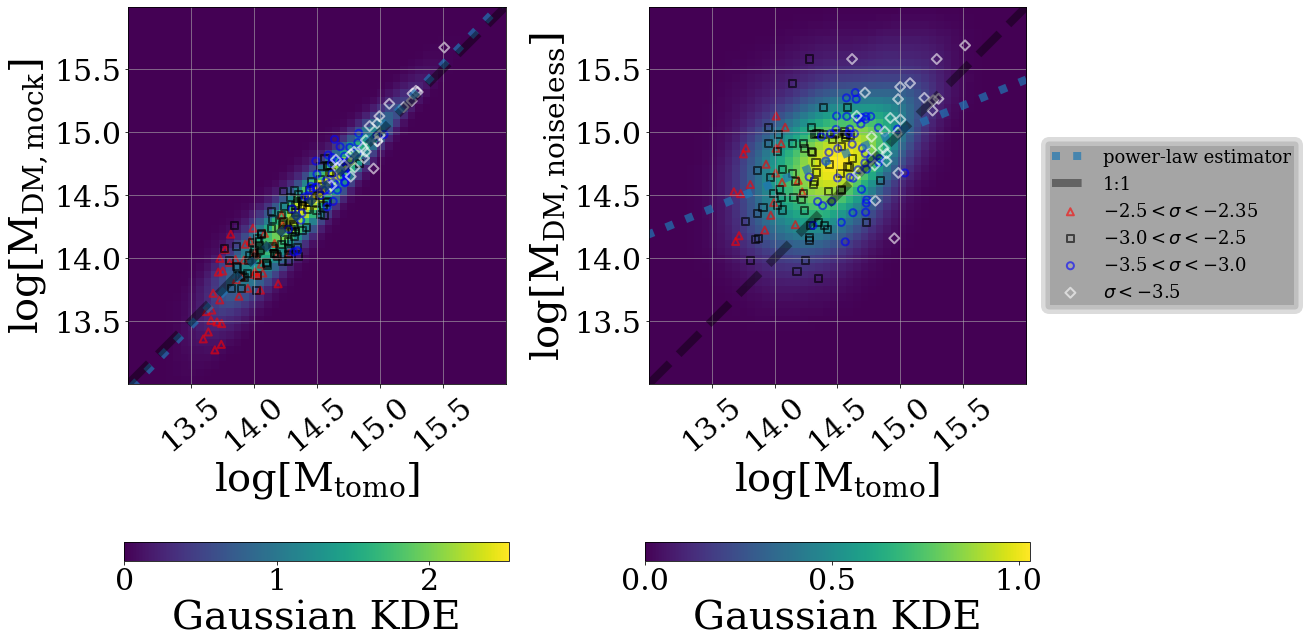

In [38]:
fig = plot_for_paper(n=7, z=2.3, th=2.35, lc=2.00, co=(0.41,14.60))

### z = 2.4

Slope :  0.392+-0.058
Intercept :  14.53+-0.043


[0.37582369141326877, 0.32914824530533393, 0.28918095184879694]

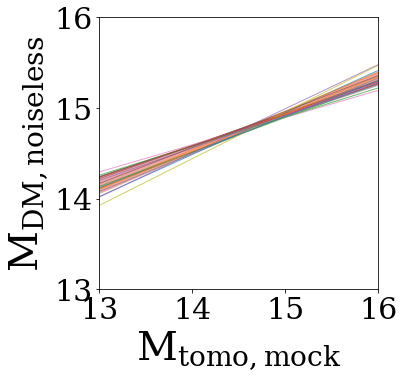

In [92]:
ntrain, co = plot_different_fits(z=2.4, th=2.35, lc=2.00)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.4, th=2.35, lc=2.00)

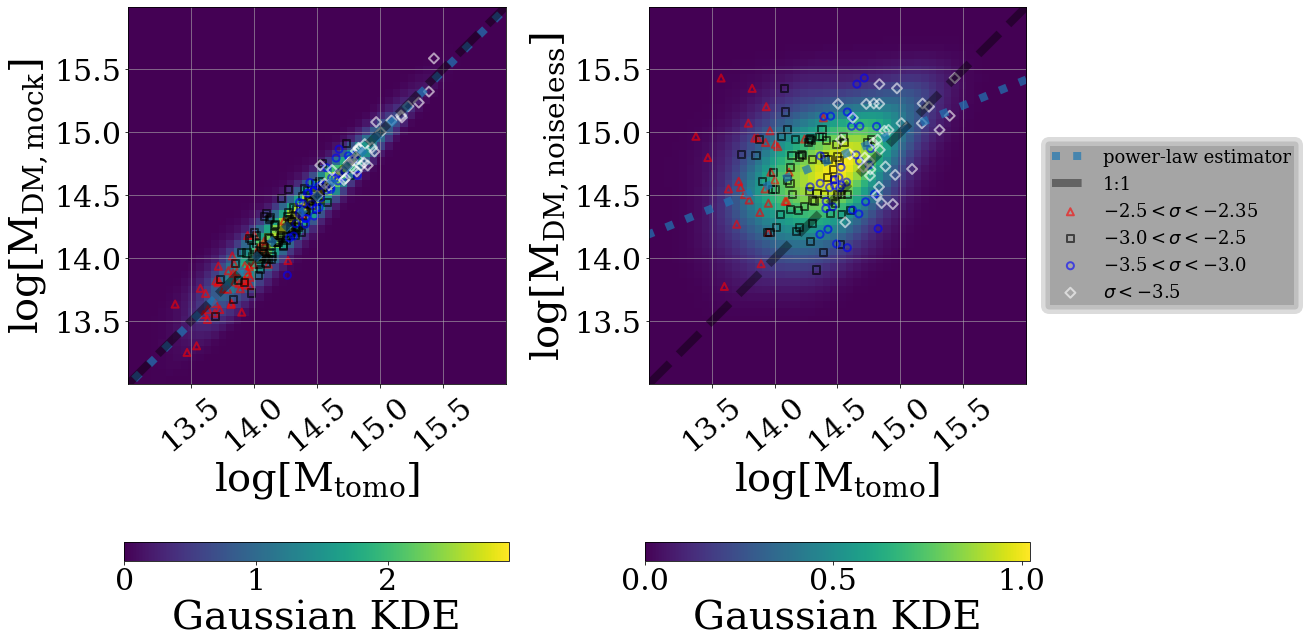

In [11]:
fig = plot_for_paper(n=7, z=2.4, th=2.35, lc=2.00, co=(0.41,14.60))

### z=2.6:
Mean estimator :

Slope :  0.345+-0.053
Intercept :  14.61+-0.032


[0.35595273269000527, 0.31010771692163563, 0.3073162374997657]

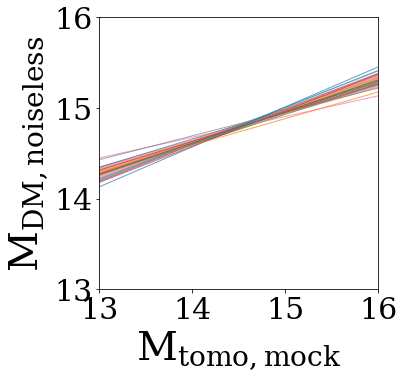

In [93]:
ntrain, co = plot_different_fits(z=2.6, th=2.35, lc=2.00)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.6, th=2.35, lc=2.00)

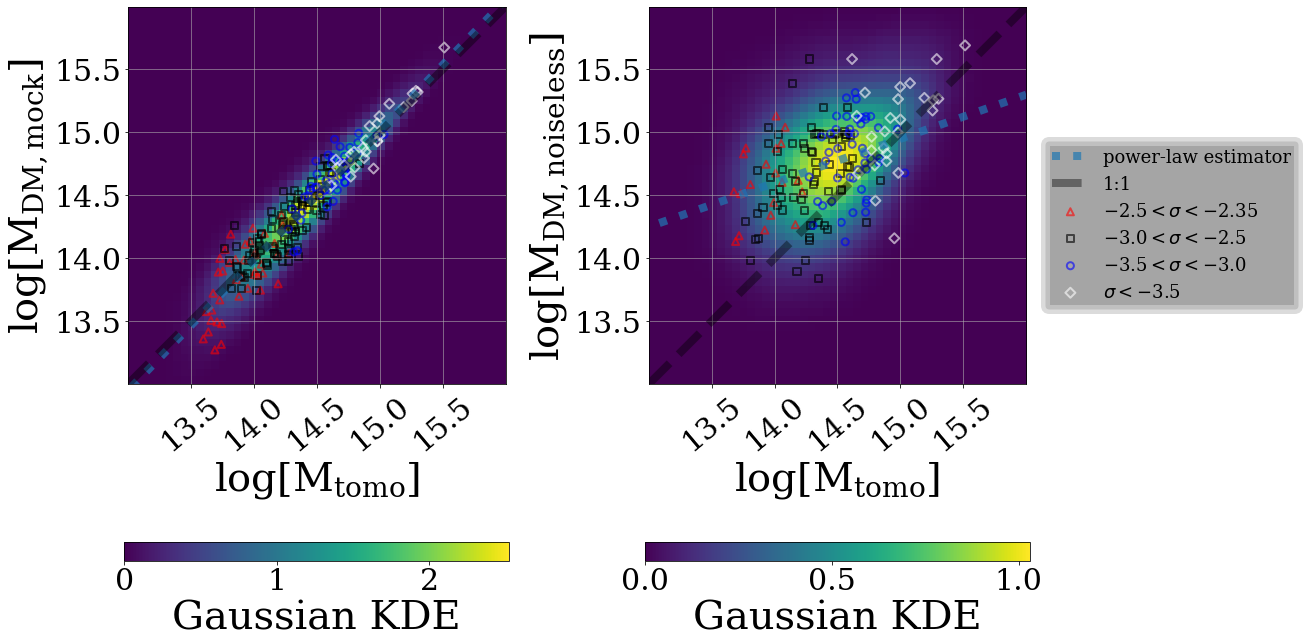

In [61]:
fig = plot_for_paper(n=7, z=2.3, th=2.35, lc=2.00, co=(0.35,14.60))

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3|  | 0.45+-0.10 | 14.62+-0.03|
|2.4|  | 0.39+-0.06 | 14.54+-0.04|
|2.6|  | 0.34+-0.05 | 14.62+-0.03|

- So, using same watershed parameters, we would only need a different offset.
- But, in real observatio

## optimized $\kappa$ and $\nu$ for each z=2.3 and 2.6 :

In [90]:
def get_offset():
    z, ls= [2.3,2.4,2.6], ['--','solid','dotted']
    lc, th = [2.35, 2.0, 1.90], [2.75, 2.35, 2.4]
    fig, ax = plt.subplots()
    ax.set_xlabel('offset (dex)')
    ax.set_ylabel(r'$rms \ M_{tomo, raw} - M_{DM, mock}$')
    for i in range(3):
        Mtomo_mock, _, MDM_mock, _, _, _ = get_MDM(n=1, z=z[i], th=th[i], lc=lc[i])
        find_optimal_offset(ax, Mtomo_mock, MDM_mock, ls=ls[i], label='z='+str(z[i]))
    ax.legend()

Minimum error is at offset =  [0.2486]
Minimum error is at offset =  [0.2133]
Minimum error is at offset =  [0.2189]


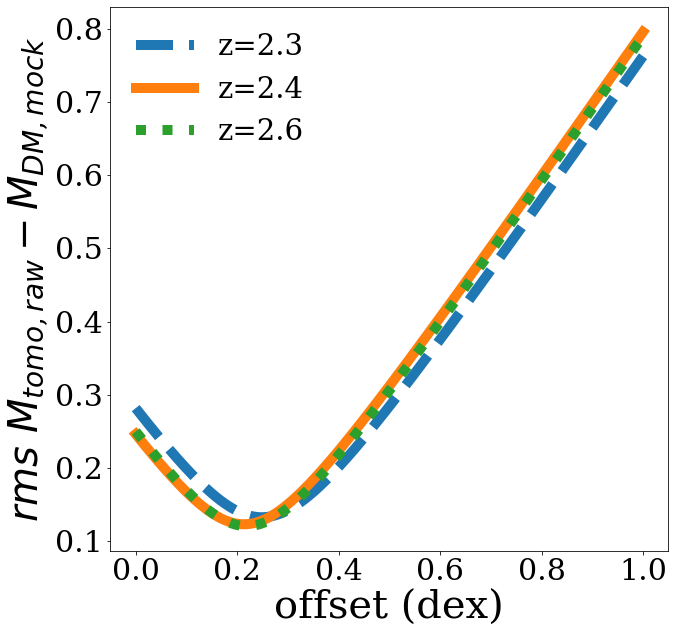

In [91]:
get_offset()

In [39]:
#write_data(z=2.3, th=2.75, lc=2.35, offset=0.249)

Slope :  0.411+-0.092
Intercept :  14.59+-0.052


[0.2952599925486169, 0.3470076475311647, 0.28581739075440804]

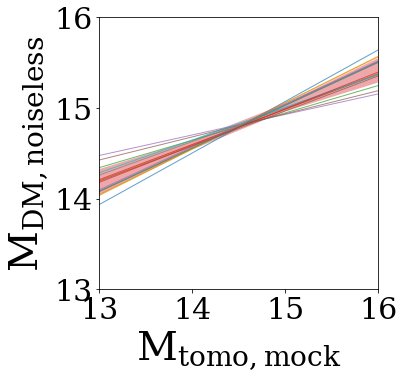

In [89]:
ntrain, co = plot_different_fits(z=2.3, th=2.75, lc=2.35)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.3, th=2.75, lc=2.35)

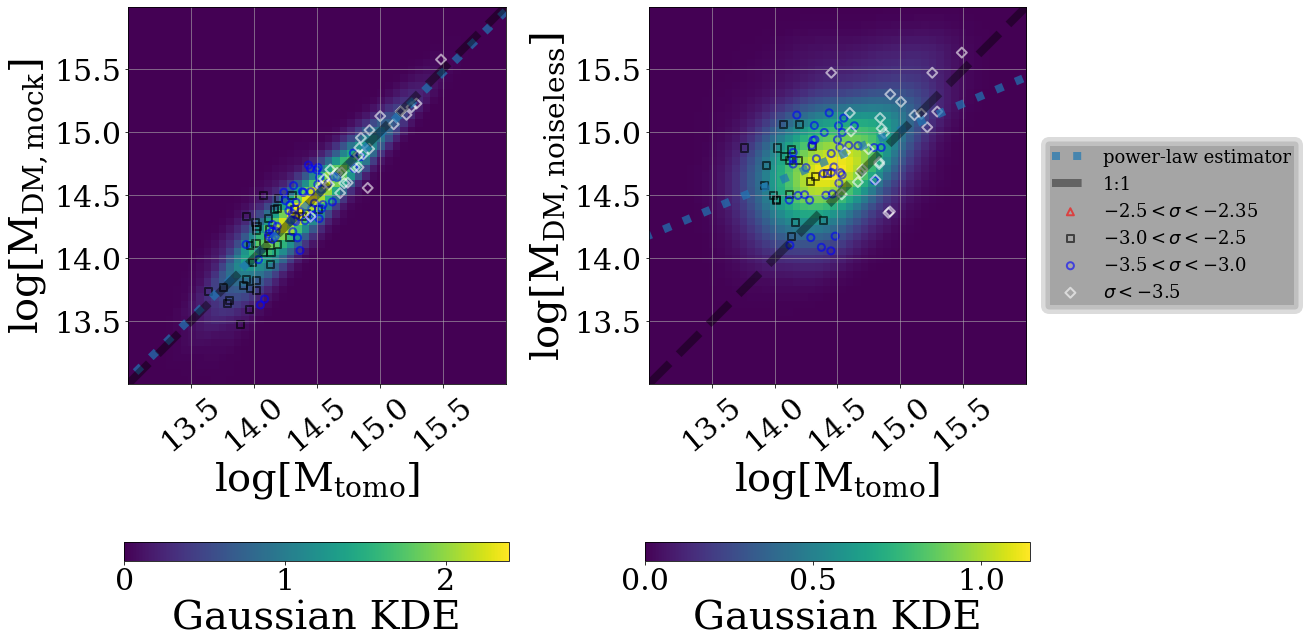

In [72]:
fig = plot_for_paper(n=7, z=2.3, th=2.75, lc=2.35, co=(0.42,14.60))

In [44]:
#write_data(z=2.6, th=2.40, lc=1.90, offset=0.22)

Slope :  0.318+-0.055
Intercept :  14.67+-0.030


[0.34622923444176795, 0.28705334651091646, 0.2700157111901264]

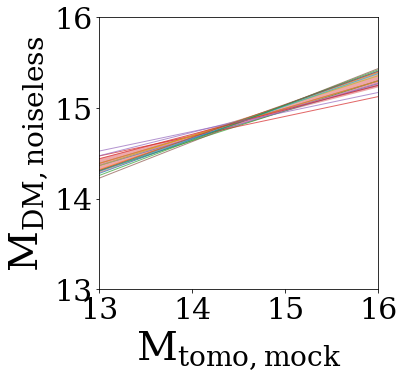

In [83]:
ntrain, co = plot_different_fits(z=2.6, th=2.40, lc=1.90)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.6, th=2.40, lc=1.90)

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3|  | 0.41+-0.10 | 14.59+-0.05|
|2.4|  | 0.39+-0.06 | 14.54+-0.04|
|2.6|  | 0.32+-0.05 | 14.67+-0.03|

Conclusion :

- $\delta_F$-$\rho_{DM}$ realtion evolves signifincantly along redshift. 
- Adopting the same relation, leads to underestimatiom of the $M_{tomo}$ for both z=2.3 and z=2.6. Therefore a larger offset is required (~ by a factor of 2 larger)
- It is weird that z=2.3 and z=2.6 behave the same.
